In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import os
import ast
from dataloader import PKDataloader
import torch

# Change the trained model name

#model_path = "t5_embed_model/"
#model_path = "deberta_embed_model/"
model_path = "MHGGNN_embed_model/"
#model_path = "chemberta_zinc_embed_model/"
#model_path = "chemberta_10m_embed_model/"

## Read output file from trained model

In [2]:
def get_training_results(model_path):
    output_file = "output.txt"
    val_epochs = []
    val_loss = []
    train_epochs = []
    train_loss = []
    with open(model_path+output_file) as f:
        for x in f:
            x = x.replace("np.float32(","").replace(")","")
            dict_line = ast.literal_eval(x)
            epoch = int(dict_line['e'])
            t_loss = float(dict_line['avgloss'])
            train_epochs.append(epoch)
            train_loss.append(t_loss)
            v_loss = dict_line.get('avgvalmse')
            if v_loss:
                val_epochs.append(epoch)
                val_loss.append(v_loss)
             
    val_epochs = np.array(val_epochs, dtype=np.int32)
    val_loss = np.array(val_loss, dtype=np.float32)  
    train_epochs = np.array(train_epochs, dtype=np.int32)  
    train_loss = np.array(train_loss,dtype=np.float32)
    return train_epochs,train_loss,val_epochs,val_loss

## Plot Training/Val error

In [3]:
def plot_train_val_error(train_epochs,train_loss,val_epochs,val_loss,mod_name):
    min_loss=val_loss.min()
    min_epoch=val_epochs[np.argmin(val_loss)]
    print(f"Min loss (val): {min_loss}, at epoch: {min_epoch}\n")
    plt.plot(train_epochs,train_loss, color='r', label='Train')
    plt.plot(val_epochs,val_loss, color='g', label='Val')
    plt.axvline(min_epoch, linestyle='--', color='blue', alpha=0.25, label='min loss')
    plt.xlabel("Epochs")
    plt.ylabel("Avg loss (MSE)")
    plt.title(f"Training/Validation error ({mod_name})")
    plt.legend()
    plt.show()

Min loss (val): 0.21500365436077118, at epoch: 990



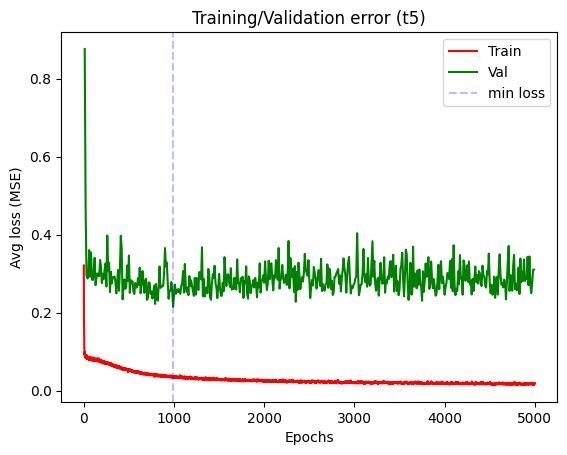

Min loss (val): 0.20853467285633087, at epoch: 1170



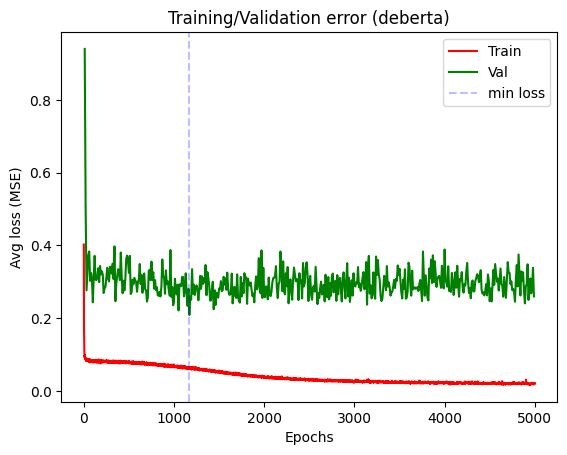

Min loss (val): 0.19199974834918976, at epoch: 1160



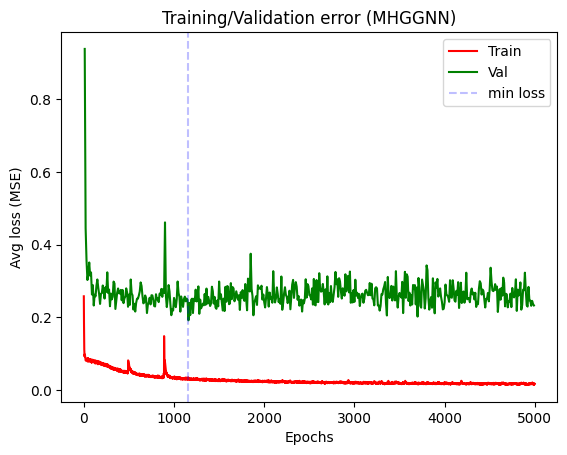

Min loss (val): 0.20855355262756348, at epoch: 4320



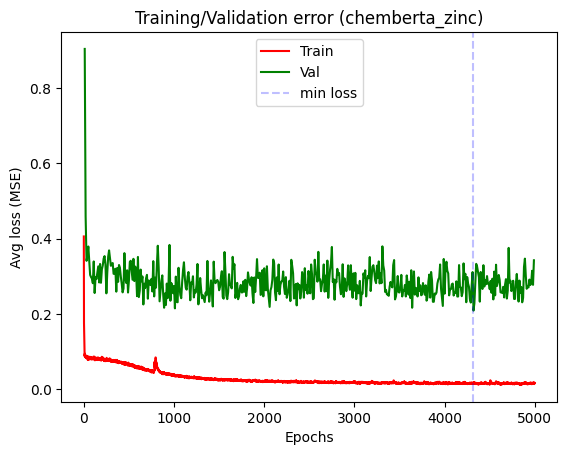

Min loss (val): 0.2188860923051834, at epoch: 1540



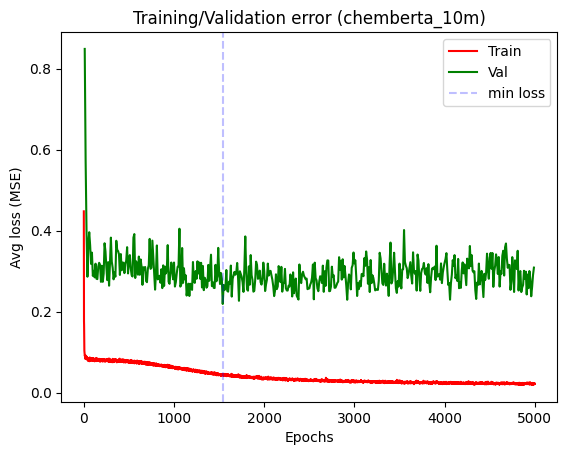

In [4]:
full_model_list = ["t5","deberta","MHGGNN","chemberta_zinc","chemberta_10m"]
for mod_name in full_model_list:
    model_path_tmp = mod_name+"_embed_model/"
    train_epochs,train_loss,val_epochs,val_loss = get_training_results(model_path_tmp)
    plot_train_val_error(train_epochs,train_loss,val_epochs,val_loss,mod_name)

Model: t5
Min loss (val): 0.21500365436077118, at epoch: 990

Model: deberta
Min loss (val): 0.20853467285633087, at epoch: 1170

Model: MHGGNN
Min loss (val): 0.19199974834918976, at epoch: 1160



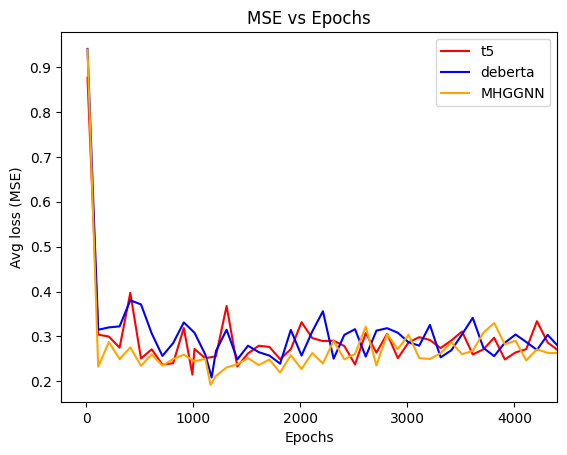

In [5]:
def plot_mse_models(model_list,color_list):
    for i,model_n in enumerate(model_list):
        mod_path = model_n+"_embed_model/"
        train_epochs,train_loss,val_epochs,val_loss = get_training_results(mod_path)
        min_loss=val_loss.min()
        min_epoch=val_epochs[np.argmin(val_loss)]
        val_epochs_inter = list(val_epochs[::10])
        val_loss_inter = list(val_loss[::10])
        val_epochs_inter.append(min_epoch)
        val_epochs_inter = sorted(val_epochs_inter)
        indx_min = val_epochs_inter.index(min_epoch)
        val_loss_inter = val_loss_inter[:indx_min] +[min_loss]+val_loss_inter[indx_min:]
        print(f"Model: {model_n}")
        print(f"Min loss (val): {min_loss}, at epoch: {min_epoch}\n")
        plt.plot(val_epochs_inter,val_loss_inter, color=color_list[i], label=model_n)
        #plt.axvline(min_epoch, linestyle='--', color='blue', alpha=0.25, label='min loss')

    plt.xlim(xmax=4400)
    plt.xlabel("Epochs")
    plt.ylabel("Avg loss (MSE)")
    plt.title("MSE vs Epochs")
    plt.legend()
    plt.show()

model_list = ["t5","deberta","MHGGNN"] #,"chemberta_zinc","chemberta_10m"]
color_list = ["red","blue","orange"] #,"green","pink"]
plot_mse_models(model_list,color_list)

Model: chemberta_zinc
Min loss (val): 0.20855355262756348, at epoch: 4320

Model: chemberta_10m
Min loss (val): 0.2188860923051834, at epoch: 1540



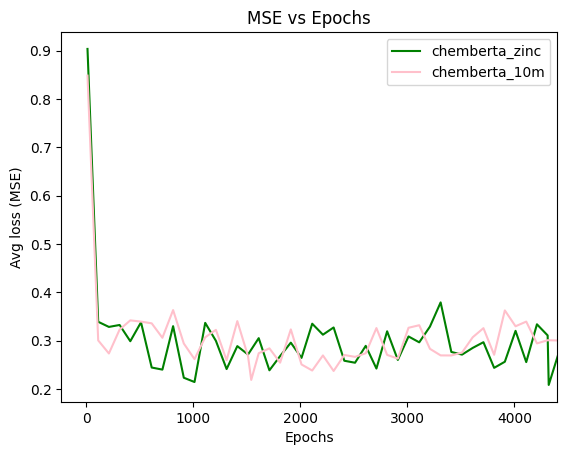

In [6]:
model_list = ["chemberta_zinc","chemberta_10m"]
color_list = ["green","pink"]
plot_mse_models(model_list,color_list)

## Create DataFrames for analysis (Synthetic/Real data)

In [7]:
adme_names = [
            'Caco2_Wang',   # 906
            'PPBR_AZ',
            'VDss_Lombardo',
            'Half_Life_Obach',
            'LD50_Zhu'
        ]


train_epochs,train_loss,val_epochs,val_loss = get_training_results(model_path)
min_loss=val_loss.min()
min_epoch=val_epochs[np.argmin(val_loss)]

csv_data_file = f'{min_epoch}_dict.csv'
df_data = pd.read_csv(model_path+csv_data_file, header=None)
df_data.head(5)

,0,1
0,CCC(=O)OCCc1ccccc1,[-0.24274446 0.7771245 -0.30218855 -0.747842...
1,CCCCC(CC)(COC(N)=O)COC(N)=O,[ 0.07951114 0.8373182 -0.74950576 -0.724481...
2,CCCCCOc1c(Br)cc(Br)cc1COCCN(CC)CC,[ 0.26958394 0.76776206 -0.75874376 -0.189136...
3,CCOP(=S)(Oc1cnn(C)c(=O)c1SCC)OC(C)C,[ 0.35111666 0.886452 -0.8823488 -0.802634...
4,CN1CC(n2nccc2-c2cc(Cl)ccc2Oc2cc(F)c(S(=O)(=O)N...,[ 0.31381384 0.87063026 -0.8564973 -0.341754...


In [8]:
for i in range(len(adme_names)):
    df_data[adme_names[i]] = df_data[1].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')[i])
df_data["class"] = df_data[0].apply(lambda x: "synthetic")
df_data.drop([0, 1], axis='columns', inplace=True)
df_data.head(5)

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,-0.242744,0.777124,-0.302189,-0.747842,0.368856,synthetic
1,0.079511,0.837318,-0.749506,-0.724481,-0.135018,synthetic
2,0.269584,0.767762,-0.758744,-0.189136,0.064061,synthetic
3,0.351117,0.886452,-0.882349,-0.802635,-0.146477,synthetic
4,0.313814,0.870630,-0.856497,-0.341755,-0.102353,synthetic


In [9]:
df_data

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,-0.242744,0.777124,-0.302189,-0.747842,0.368856,synthetic
1,0.079511,0.837318,-0.749506,-0.724481,-0.135018,synthetic
2,0.269584,0.767762,-0.758744,-0.189136,0.064061,synthetic
3,0.351117,0.886452,-0.882349,-0.802635,-0.146477,synthetic
4,0.313814,0.870630,-0.856497,-0.341755,-0.102353,synthetic
...,...,...,...,...,...,...
1043,0.363772,0.023866,-0.942384,-0.254754,0.028339,synthetic
1044,-0.038880,0.899957,-0.692893,-0.729414,-0.182523,synthetic
1045,0.346031,0.973259,-0.832165,-0.989788,0.323149,synthetic
1046,-0.533386,0.898693,-0.707945,-0.784523,-0.084676,synthetic


In [10]:
csv_data_gt_file = 'gt_dict.csv'
df_data_gt = pd.read_csv(model_path+csv_data_gt_file)
df_data_gt

,sm,ft,ma,gt
0,CC(=Cc1ccccc1)CO,[-2.7243981 1.0236673 0.14847678 ... 0. ...,[False False False False True],[ 0.78245112 0.8378451 -0.90773698 -0.361312...
1,Nc1nc2cc(Br)ccc2o1,[-14.295192 19.71878 -3.2047384 ... 0. ...,[False False False False True],[-0.17427598 0.28787434 -0.96237816 -0.581438...
2,CN(C)C(=O)Nc1ccc(Cl)cc1,[-9.733939 9.883936 -5.478608 ... 0. ...,[False False False False True],[-0.27517787 -0.05015072 -0.67062738 -0.942257...
3,COc1cc(OC)c(S(=O)(=O)N(c2ccccc2)C(C)C)cc1NC(C)=O,[ 15.987561 -47.37958 26.101778 ... 0. ...,[False True False False False],[ 0.34996092 0.97341211 -0.63806327 -0.930851...
4,CCCN(CCC)C(=O)C(Cc1ccc(OCCN(CC)CC)cc1)NC(=O)c1...,[-8.842045 5.3536453 -6.024255 ... 0. ...,[False False False False True],[ 0.24745579 0.81330944 -0.92887465 -0.818577...
...,...,...,...,...
1043,O=c1cc(N2CCOCC2)nc(NCc2ccccc2)[nH]1,[-4.279455 1.2922261 -6.774044 ... 0. ...,[False True False False False],[ 0.56376617 -0.57104874 -0.81611779 -0.171838...
1044,CCCCCCCCCCCCCCCCO,[-9.614815 -1.1694193 4.5702586 ... 0. ...,[False False False False True],[ 0.48259946 0.89413408 -0.15689441 -0.923438...
1045,C=CC(=O)OC1CC2CCC1(C)C2(C)C,[13.3814125 -1.6242306 11.792306 ... 0. ...,[False False False False True],[-0.18438419 -0.23134621 -0.60350296 -0.827964...
1046,CCOP(=O)(OCC)SC1CS(=O)CC1Cl,[-14.671788 3.9272094 -3.6890314 ... 0. ...,[False False False False True],[-0.21355871 0.92941266 -0.62132694 -0.952980...


In [11]:
df_data_gt = df_data_gt[['sm','gt']]
for i in range(len(adme_names)):
    df_data_gt[adme_names[i]] = df_data_gt['gt'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ')[i])
df_data_gt["class"] = df_data_gt['sm'].apply(lambda x: "real")
df_data_gt.drop(['sm', 'gt'], axis='columns', inplace=True)
df_data_gt

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,0.782451,0.837845,-0.907737,-0.361313,-0.334812,real
1,-0.174276,0.287874,-0.962378,-0.581439,-0.096674,real
2,-0.275178,-0.050151,-0.670627,-0.942258,-0.119734,real
3,0.349961,0.973412,-0.638063,-0.930852,-0.471552,real
4,0.247456,0.813309,-0.928875,-0.818578,0.098004,real
...,...,...,...,...,...,...
1043,0.563766,-0.571049,-0.816118,-0.171838,-0.122617,real
1044,0.482599,0.894134,-0.156894,-0.923438,-0.381375,real
1045,-0.184384,-0.231346,-0.603503,-0.827964,-0.406652,real
1046,-0.213559,0.929413,-0.621327,-0.952980,0.708647,real


In [12]:
df_full_data = pd.concat([df_data,df_data_gt], axis=0)
df_full_data

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu,class
0,-0.242744,0.777124,-0.302189,-0.747842,0.368856,synthetic
1,0.079511,0.837318,-0.749506,-0.724481,-0.135018,synthetic
2,0.269584,0.767762,-0.758744,-0.189136,0.064061,synthetic
3,0.351117,0.886452,-0.882349,-0.802635,-0.146477,synthetic
4,0.313814,0.870630,-0.856497,-0.341755,-0.102353,synthetic
...,...,...,...,...,...,...
1043,0.563766,-0.571049,-0.816118,-0.171838,-0.122617,real
1044,0.482599,0.894134,-0.156894,-0.923438,-0.381375,real
1045,-0.184384,-0.231346,-0.603503,-0.827964,-0.406652,real
1046,-0.213559,0.929413,-0.621327,-0.952980,0.708647,real


## Univariate plots

In [13]:
df_data_gt.describe()

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,0.124923,0.576423,-0.642104,-0.534859,-0.037875
std,0.369158,0.508468,0.417145,0.458755,0.369662
min,-0.986199,-1.015703,-1.003702,-1.027165,-0.877476
25%,-0.153555,0.414363,-0.931151,-0.874282,-0.298704
50%,0.167641,0.786379,-0.804722,-0.721216,-0.099166
75%,0.414553,0.932438,-0.515038,-0.298558,0.169908
max,0.860267,1.021326,1.009337,1.000000,0.980488


In [14]:
df_data.describe()

,Caco2_Wang,PPBR_AZ,VDss_Lombardo,Half_Life_Obach,LD50_Zhu
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,0.133720,0.671709,-0.677839,-0.618739,-0.069550
std,0.268733,0.351842,0.292090,0.280619,0.309349
min,-0.773847,-0.854230,-1.000000,-1.000000,-0.862527
25%,-0.029565,0.620580,-0.864669,-0.811014,-0.294608
50%,0.159603,0.791378,-0.753149,-0.678777,-0.133651
75%,0.330595,0.879854,-0.585485,-0.479516,0.099224
max,0.817319,1.000000,0.697756,0.842312,0.916417


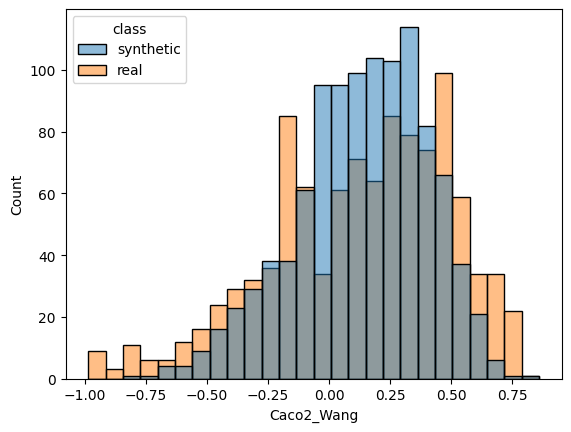

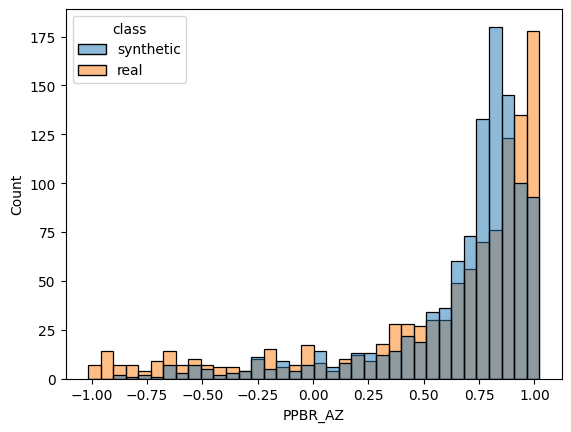

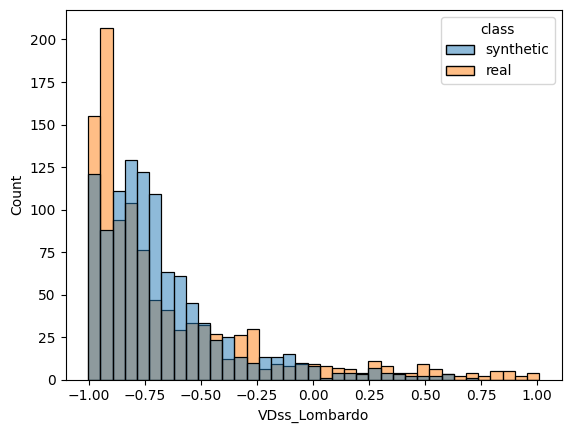

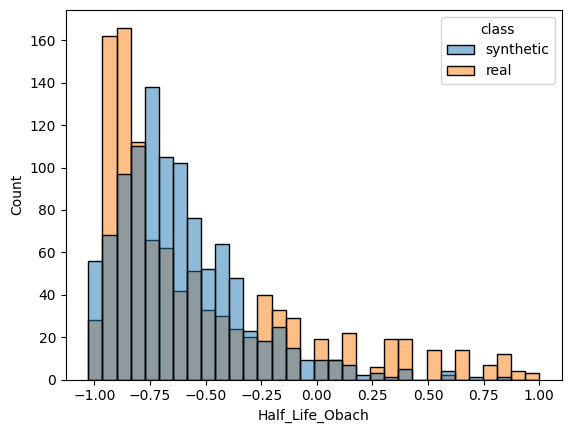

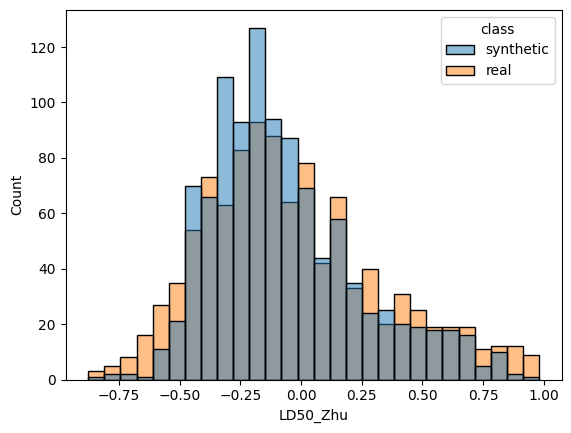

In [15]:
#g = sns.FacetGrid(df_full_data, col="class")
#g.map(sns.histplot, "Caco2_Wang")
for ft_name in adme_names:
    sns.histplot(x=ft_name, data=df_full_data, hue='class')
    plt.show()

## Bivariate plots

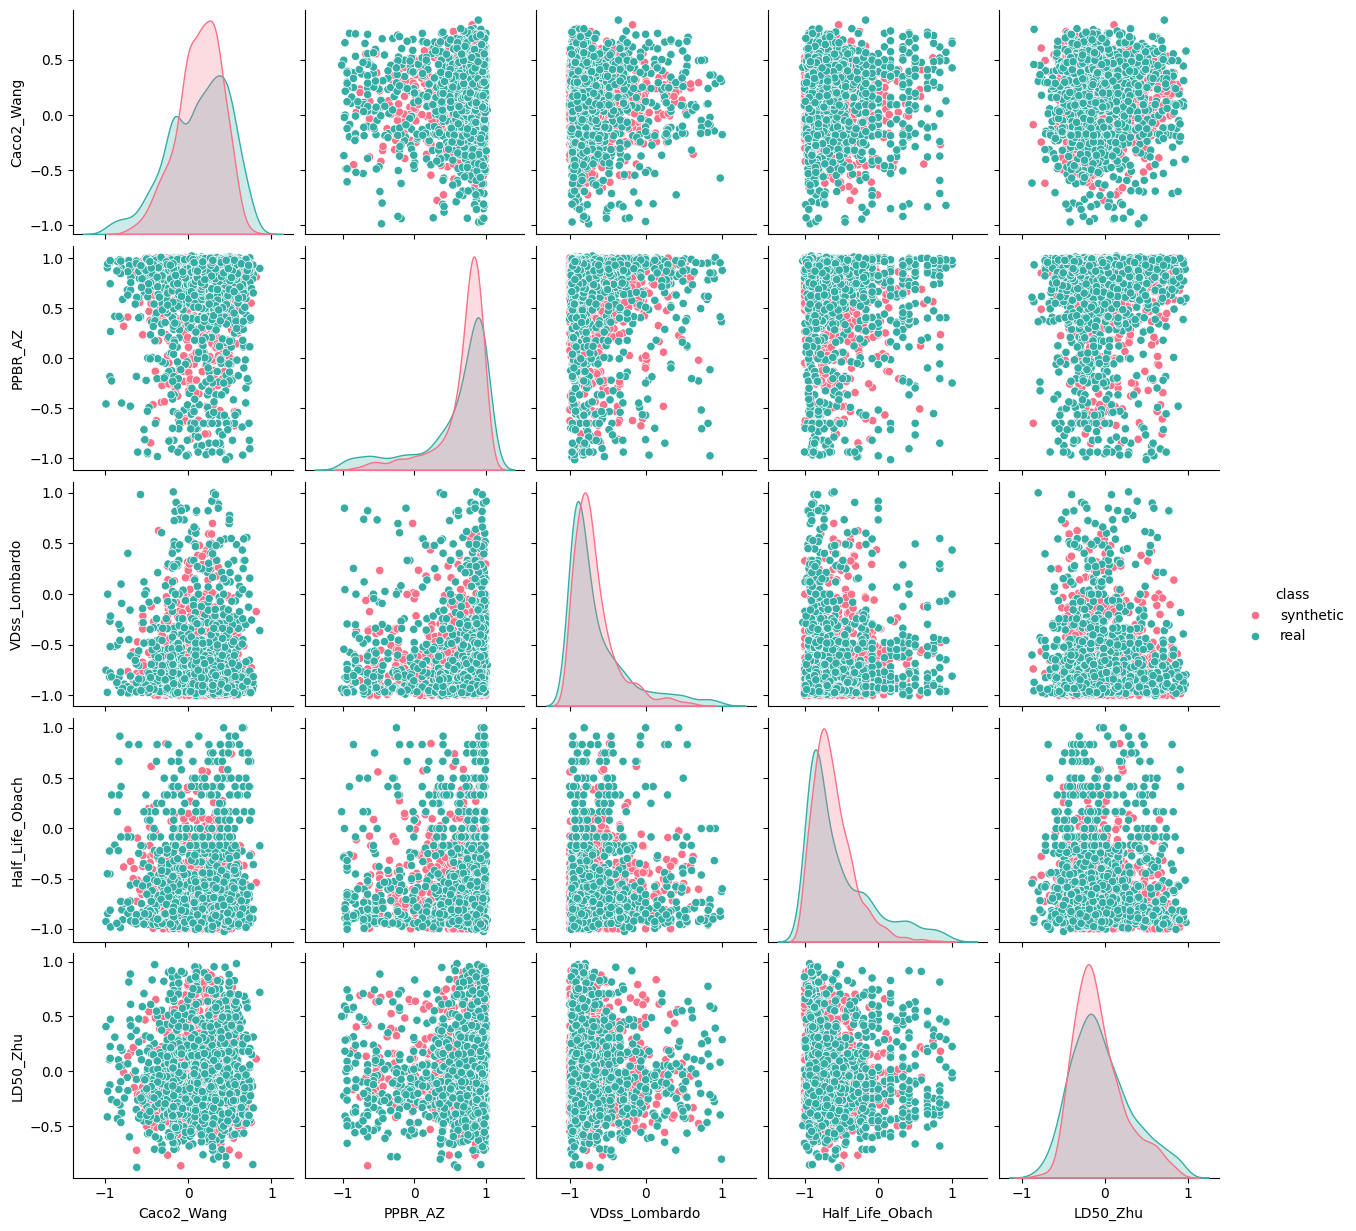

In [16]:
sns.pairplot(data=df_full_data, hue="class", diag_kind="kde", palette="husl")
plt.show()

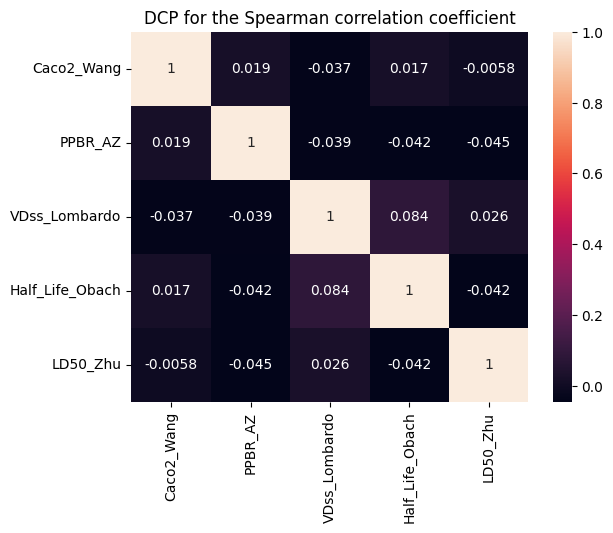

In [17]:
corr = df_full_data[adme_names].corr(method = 'spearman')
sns.heatmap(corr, annot = True)
plt.title("DCP for the Spearman correlation coefficient")
plt.show()

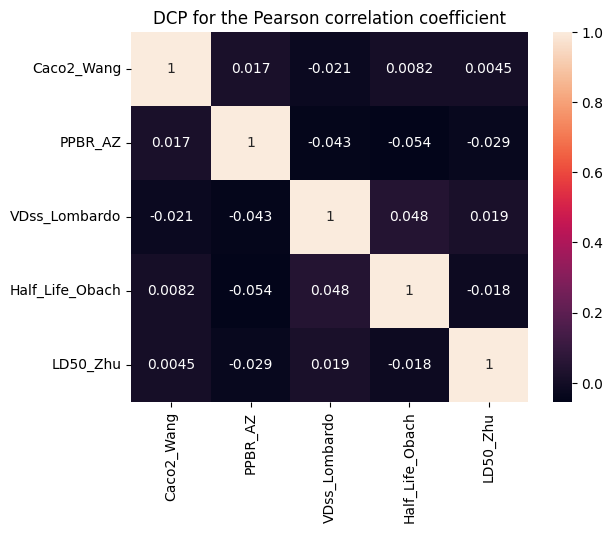

In [18]:
corr = df_full_data[adme_names].corr(method = 'pearson')
sns.heatmap(corr, annot = True)
plt.title("DCP for the Pearson correlation coefficient")
plt.show()